# Finding the Best Neighbourhood

## Introduction

## The Metric

## Importing Data

In [42]:
# Set Up
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

#Imports the neighborhoods GDF
neighborhood_gdf = geopandas.read_file("Neighborhoods_.shp").set_index('hood')
#Correcting for some oddities in neighborhoods data where sqmiles is plain wrong for select neighborhoods
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212
neighborhood_gdf.at['Lincoln-Lemington-Belmar','sqmiles'] = 1.812
neighborhood_gdf.at['Marshall-Shadeland','sqmiles'] = 1.254

## Arrests

In [43]:
# Arrest Data
#Reads Dom's arrest csv and filters by years
arrest = pd.read_csv("arrests.csv")
arrest_mask = (arrest["ARRESTTIME"].str[:4].astype('int') >= 2017) & (arrest["ARRESTTIME"].str[:4].astype('int') <= 2020)
arrest_4 = arrest[arrest_mask]

#Adds column for Dom's arrests labeled 'arrests'
filterarrest = arrest_4.groupby("INCIDENTNEIGHBORHOOD")["OFFENSES"].count()
filterarrest=filterarrest.rename(index={'Mt. Oliver Neighborhood':'Mt. Oliver'})
try:
    neighborhood_gdf.insert(0,"arrests",filterarrest)
except ValueError:
    neighborhood_gdf['arrests'] = filterarrest
neighborhood_gdf['arrests'] = neighborhood_gdf['arrests'].fillna(0)

### Fire Incidents

The data for this section came from the WPRDC website's fire alarm data.

In order to properly organise the data I got, I imported th data from the csv file into a python **dictionary**. This way, I can easily print out the content of the data I need in ways I want to present it.

In order to align the dates of the data, I filter the incoming data so only fire alarm data from the year 2017-2020 will be taken into acccount.

After the importing is done, I will make a dataframe out of the dictionary, and conatenate the dataframe to the overall dataframe.|

In [44]:
# Fire Incident data
#Reads Alex's fire incidents csv
fire_data = pd.read_csv("Fire_Alarm.csv")
#Adds column for Alex's fire incidents labeled 'fires'
neighbourhood_dictionary = {}
name = ""
counter = 0
neighbourhood_counter = 0
# put all data into a dictionary
for index, row in fire_data.iterrows():
    neighborhood = row["neighborhood"]
    time = row["alarm_time"]
    if(type(time) == str):
        if(time.startswith("2017") or time.startswith("2018") or time.startswith("2019") or time.startswith("2020")):
            if(neighborhood not in neighbourhood_dictionary.keys()):
                neighbourhood_dictionary.update({neighborhood: [neighborhood, 1]})
                continue
            counter = neighbourhood_dictionary[neighborhood]
            counter[1] += 1
            neighbourhood_dictionary.update({neighborhood: counter})
# Import the data from the dictionary into a dataframe
neighborhood_df = pd.DataFrame.from_dict(neighbourhood_dictionary, orient = "index")
neighborhood_df.columns = ["Neighbourhood", "Number of Incidents"]
neighborhood_df = neighborhood_df.dropna()
neighborhood_df = neighborhood_df.drop(index=['Mount Oliver Borough'])
# Add the dataframe's value to the concatenate dataframe
try:
    neighborhood_gdf.insert(1,"fires", neighborhood_df['Number of Incidents'])
except ValueError:
    neighborhood_gdf['fires'], neighborhood_df['Number of Incidents']
neighborhood_gdf['fires'] = neighborhood_gdf['fires'].fillna(0)

### Car Crashes
Here, I took data from the Allegheny County Car Crashes data set, which spans from 2004 to 2020.

I used query masking to filter out any data that wasn't from 2017 to 2020 as that's where out three data sets lined up.

I looped through the neighborhoods and used the within method (part of geopandas) to count the crashes in each neighborhood and add that data as a column of nieghborhood_gdf.

In [45]:
# Crash Data
#Reads Sean's crashes csv and filters by years
crashes_df = pd.read_csv("crashes.csv", low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])
crashes_mask = (crashes_df['CRASH_YEAR'] >= 2017) & (crashes_df['CRASH_YEAR'] <= 2020)
crashes_4 = crashes_df[crashes_mask]
crashes_gdf = geopandas.GeoDataFrame(crashes_4, geometry=geopandas.points_from_xy(crashes_4.DEC_LONG, crashes_4.DEC_LAT, crs=4326))

#Adds column for Sean's crashes labeled 'crashes'
crash_count = pd.Series(index=neighborhood_gdf.index, data=0, dtype=int)
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        crash_count[i] = bool_crashes.value_counts().loc[True]
    except KeyError:
        continue
try:
    neighborhood_gdf.insert(1, "crashes", crash_count)
except ValueError:
    neighborhood_gdf['crashes'] = crash_count
neighborhood_gdf = neighborhood_gdf.assign(crashes_sqmile = lambda x: x['crashes'] / x['sqmiles'])

In [38]:
#Adds columns to neighborhood_gdf for x per square mile
neighborhood_gdf = neighborhood_gdf.assign(arrests_sqmile = lambda x: x['arrests'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(fires_sqmile = lambda x: x['fires'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_sqmile = lambda x: x['crashes'] / x['sqmiles'])

## Plotting the Data

### Arrests

,sqmiles,arrests,arrests_sqmile
hood,,,
East Allegheny,0.236,1366.0,5788.135593
Central Business District,0.640,2614.0,4084.375000
Allegheny Center,0.210,771.0,3671.428571
Homewood South,0.398,1409.0,3540.201005
Homewood North,0.434,1288.0,2967.741935


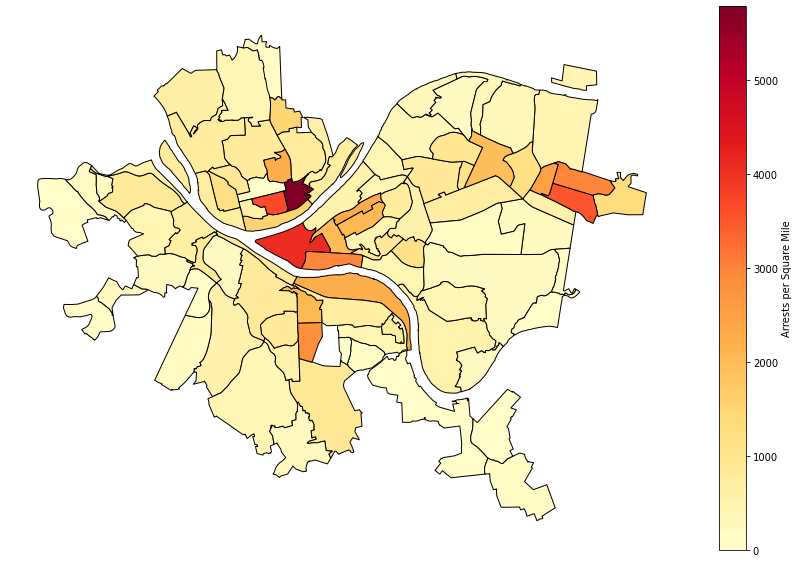

In [32]:
#Arrests Plot
neighborhood_gdf.plot(figsize=(15,10), column = "arrests_sqmile",
                    cmap = "YlOrRd",
                   legend = True,
                   legend_kwds = {"label":"Arrests per Square Mile"},
                   edgecolors = "black")
plt.axis("off")
neighborhood_gdf.sort_values('arrests_sqmile', ascending=False)[['sqmiles','arrests','arrests_sqmile']].head(5)

### Fire Incidents

For this section, we will look at the number of fire incidents per square mile of each neighbourhood.

But before we plot the data out, lets take a look at the top 10 most livable neighbourhood in Pittsburgh. 

To organise the data, again, I used python **dictionary** to help me visualise the data.

In [25]:
# Top 10 Best Neighbourhood For Fire Incidents Per Square Mile
fire_sqmiles_dict = {}
hood_name = neighborhood_gdf.index.tolist()
fire_sqmiles_value = neighborhood_gdf["fires_sqmile"].tolist()
i = 0
for x in hood_name:
    fire_sqmiles_dict.update({x: int(fire_sqmiles_value[i])})
    i += 1
temp = sorted(fire_sqmiles_dict, key=fire_sqmiles_dict.get, reverse=True)
i = 0
for x in temp:
    if i > 9: break
    print(i+1, ":", x,", Fire Incident Per Square Mile:", fire_sqmiles_dict[x])
    i+=1
# YES THIS IS WAY MORE COMPLICATED THAN IT NEEDS TO BE BUT IT WORKS

1 : East Allegheny , Fire Incident Per Square Mile: 224
2 : Knoxville , Fire Incident Per Square Mile: 215
3 : Central Northside , Fire Incident Per Square Mile: 169
4 : Bluff , Fire Incident Per Square Mile: 155
5 : Homewood South , Fire Incident Per Square Mile: 135
6 : Homewood North , Fire Incident Per Square Mile: 135
7 : Central Business District , Fire Incident Per Square Mile: 131
8 : Allentown , Fire Incident Per Square Mile: 125
9 : Middle Hill , Fire Incident Per Square Mile: 111
10 : Crawford-Roberts , Fire Incident Per Square Mile: 104


Then we will plot the data out with **geopandas** to see if the results match.

(-80.10681367594599, -79.8543203064025, 40.35464264383522, 40.50793369806537)

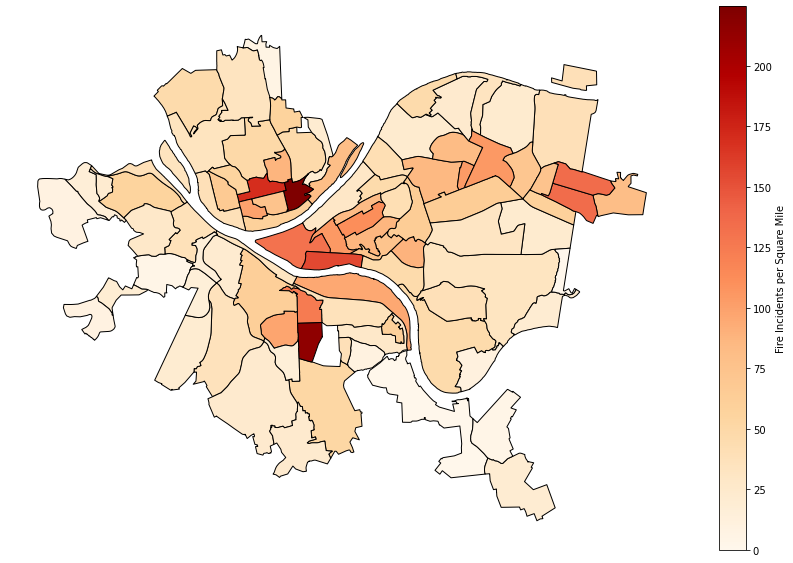

In [27]:
#Fire Incidents Plot
neighborhood_gdf.plot(column='fires_sqmile',
              cmap='OrRd',            
              edgecolor="black",      
              legend=True,              
              legend_kwds={'label': "Fire Incidents per Square Mile"}, 
              figsize=(15, 10),         
              )
plt.axis("off")

So, as the data shown, the most livable neighbourhood in Pittsburgh, according to the number of fire incidents alone, will be **East Allegheny**, coming in at second place is **Knoxville**, and coming in at third place is **Central Northside**.

But nonetheless, this only accounts for 1/3 of the total data used for the final calculation, and all the neighbourhood will be taken into account for the final calculation, no matter the ranking they got here.

### Car Crashes
Here, we plot the car crashes per square mile in each neighborhood. In first place is **Bluff**, with over 1500 crashes per square mile. Not far behind in second place is the **Central Business District**, more commonly known as Downtown. In third is **East Allegheny** with nearly 1300 crashes per square mile over 4 years.

,sqmiles,crashes,crashes_sqmile
hood,,,
Bluff,0.327,504,1541.284404
Central Business District,0.640,913,1426.562500
East Allegheny,0.236,300,1271.186441
South Shore,0.212,242,1141.509434
West End,0.200,207,1035.000000


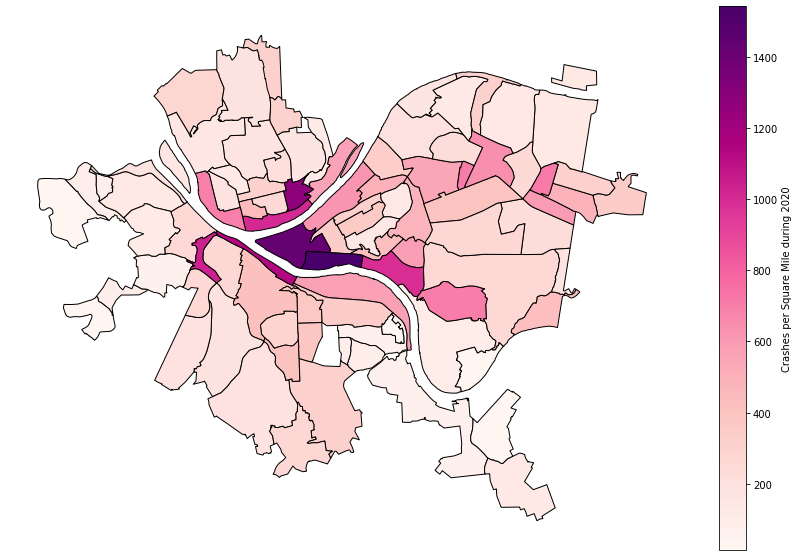

In [39]:
#Crashes Plot
neighborhood_gdf.plot(column='crashes_sqmile',
                      cmap="RdPu",
                      edgecolor="black",
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile during 2020'},
                      figsize=(15,10))
plt.axis('off')
neighborhood_gdf.sort_values('crashes_sqmile', ascending=False)[['sqmiles','crashes','crashes_sqmile']].head(5)

### Final Results
To get the final results, we score each neighborhood on a linear scale where it's score for X category is the it's metric for that category divided by the maximum of that category among all neighborhoods.

For example, it the maximum arrests per square mile among all neighborhoods is 50 and neighborhood Y had 25 arrests per square mile, it's score for arrests would be 25 / 50 = 0.5.

To get the overall score, we simply take the average of our scoring system for each of the individual categories and multiply that by 100. This way, we get a nice number out of 100 and each neighborhood is weighted equally.

In [34]:
max_series = neighborhood_gdf[['arrests_sqmile','fires_sqmile','crashes_sqmile']].max()
neighborhood_gdf = neighborhood_gdf.assign(arrests_1 = lambda x: x['arrests_sqmile'] / max_series['arrests_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(fires_1 = lambda x: x['fires_sqmile'] / max_series['fires_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_1 = lambda x: x['crashes_sqmile'] / max_series['crashes_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(score = lambda x: (x['arrests_1'] + x['fires_1'] + x['crashes_1']) / 3 * 100)

,sqmiles,arrests,fires,crashes,arrests_sqmile,fires_sqmile,crashes_sqmile,score
hood,,,,,,,,
East Allegheny,0.236,1366.0,53.0,300,5788.135593,224.576271,1271.186441,94.158596
Central Business District,0.640,2614.0,84.0,913,4084.375000,131.250000,1426.562500,73.854912
Bluff,0.327,963.0,51.0,504,2944.954128,155.963303,1541.284404,73.442320
Knoxville,0.302,857.0,65.0,117,2837.748344,215.231788,387.417219,56.667348
Homewood South,0.398,1409.0,54.0,196,3540.201005,135.678392,492.462312,51.176590


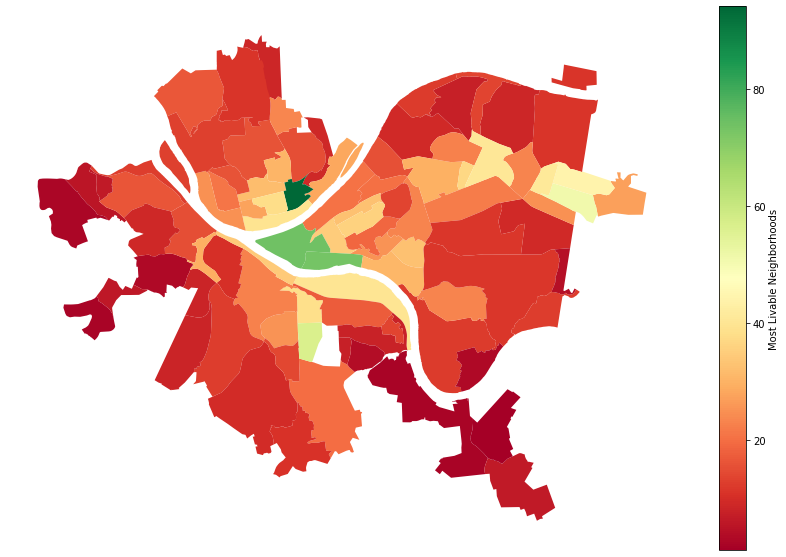

In [37]:
neighborhood_gdf.plot(column='score',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Most Livable Neighborhoods'},
                      figsize=(15,10))
plt.axis('off')
neighborhood_gdf.sort_values('score', ascending=False)[['sqmiles','arrests','fires','crashes','arrests_sqmile', 'fires_sqmile','crashes_sqmile','score']].head(5)

## Final Conclusion

Overall, our in-depth analysis shows that East Allegheny is in fact the best neighborhood in Pittsburgh. It just makes sense, winning the Gold in arrests per square mile, another Gold in fire incidents per square mile, and the Bronze in car crashes per square mile.

### Alex's Conclusion

So from the final results, we know that **East Allegheny** won out as the most livable neighbourhood. And from the fire incident data, we know that **East Allegheny** came in second for that section. My head horse, **Knoxville**, ended up coming in fifth. I am not very suprised with the result since **Knoxville** did not have a giant lead over **East Allegheny**. But overall I'd say fire incident data is a great reflection of the final result as the top 10 most livable neighbourhood according to fire incidents alone a place relatively high on the final list.

### Sean's Conclusion
I'm from Brookline so it would have been nice to have my own neighborhood as our best neighborhood, but unfortunatley Brookline came in about 70th place. Admittedly Brookline doesn't have much chaos over the great East Allegheny. I am actually quite surprised by East Allegheny coming in first though. I've lived in Pittsburgh for 19 years now and have never heard much of anything about East Allegheny. I would've expected Downtown or maybe Homewood to come in first, but East Allegheny, a neighborhood I hardly even knew was a neighborhood, takes the cake as most Chaotic neighborhood.